In [1]:
from copy import deepcopy

import pandas as pd
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float64)

# plt.style.use(['dark_background', 'bmh'])
plt.style.use(['seaborn-v0_8-whitegrid', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='w')
plt.rc('figure', figsize= (6, 3), dpi=150)

import warnings
warnings.filterwarnings('ignore')

import os
dir_fitted_result = './fitted_GPModels'
os.makedirs(dir_fitted_result, exist_ok = True)

dir_trainset = './trainset'
os.makedirs(dir_trainset, exist_ok = True)

c:\Users\user\anaconda3\envs\CPKL_GPytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Examples for sample size**
- For 1d-Dataset: `torch.Size([20]) torch.Size([20]) torch.Size([100]) torch.Size([100])`  
- For 2d-dataset: `torch.Size([20, 2]) torch.Size([20]) torch.Size([100, 2]) torch.Size([100])`  
- For nd-dataset: `torch.Size([20, n]) torch.Size([20]) torch.Size([100, n]) torch.Size([100])`

### **Define functions for case studies**

In [2]:
from gpytorch.kernels import RBFKernel, LinearKernel, RQKernel, MaternKernel, CosineKernel, PeriodicKernel

def define_base_kernels(train_x, traindata_info):

    # Set active dimensions
    action_dims = torch.tensor([i for i in range(0, train_x.dim())])

    lengthscale_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_x'], traindata_info['max_dist_x'] - traindata_info['min_dist_x'])
    variance_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_y'], traindata_info['max_dist_y'] - traindata_info['min_dist_y'])
    periodlength_prior = gpytorch.priors.NormalPrior(
        traindata_info['med_dist_x'], traindata_info['max_dist_x'] - traindata_info['min_dist_x'])

    period_length_constraint = gpytorch.constraints.Interval(
        0.5*traindata_info['min_dist_x'], traindata_info['max_dist_x']*1.5)

    for i in range(0, train_x.dim()):
        if i == 0:
            lin_ken = LinearKernel(active_dims=i, variance_prior=variance_prior, variance_constraint=gpytorch.constraints.Interval(
                0.5*traindata_info['min_dist_y'], traindata_info['max_dist_y']*1.5))

            # Samller values of period_length means higher frequency in signals
            cos_ken = CosineKernel(active_dims=i, period_length_prior=periodlength_prior, period_length_constraint=gpytorch.constraints.Interval(
                0.5 * traindata_info['min_dist_x'], traindata_info['max_dist_x'] * 1.5))
            cos_ken1 = CosineKernel(active_dims=i, period_length_prior=periodlength_prior,
                                    period_length_constraint=gpytorch.constraints.LessThan(0.5*traindata_info['min_dist_x']))

        else:
            lin_ken *= lin_ken
            cos_ken *= cos_ken
            cos_ken1 *= cos_ken1

    # define the kernels
    base_kernels = {
        'rbf': lambda: RBFKernel(active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'lin': lambda: lin_ken,
        # 'cos': lambda: cos_ken,
        # 'cos1': lambda: cos_ken1,
        # 'per': lambda: PeriodicKernel(active_dims=action_dims, ard_num_dims=len(action_dims),
        #                             period_length_prior=periodlength_prior, lengthscale_prior=lengthscale_prior,
        #                             period_length_constraint = period_length_constraint),
        'rq': lambda: RQKernel(active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior,),
        'mat12': lambda: MaternKernel(nu=0.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'mat32': lambda: MaternKernel(nu=1.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
        'mat52': lambda: MaternKernel(nu=2.5, active_dims=action_dims, ard_num_dims=len(action_dims), lengthscale_prior=lengthscale_prior),
    }

    # base_likelihood = lambda: gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())

    def base_likelihood(): return gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-3))

    # Assume: likelihood noise constraint was defined so that 1e-4 is within range.
    likelihood0 = base_likelihood()
    if 0:
        # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
        likelihood0.noise = 1e-4
        # Mark that we don't want to train the noise.
        likelihood0.noise_covar.raw_noise.requires_grad_(False)

    return base_kernels, likelihood0

In [3]:
from Util_CPKL import *

def run_experimental_data_for_CPKL(trainset, testset, rand_seed0, options, plot_result_on = False):
    # Run CPKL
    multi_restart_option = {}
    multi_restart_option['sampling'] = 'random'
    multi_restart_option['n_eval'] = 20
    
    # Assign input and output from tuples
    train_y_all, train_x_all = trainset
    test_y_all, test_x_all  = testset

    train_x, test_x = train_x_all.float(), test_x_all.float()
    train_y, test_y =  train_y_all.float(), test_y_all.float()
    
    # get information trainint set for initializing hyper-parameters
    traindata_info = initialize_hyperparameters(train_x, train_y)
    multi_restart_option['traindata_info'] = traindata_info
    
    # Define base_kernels
    base_kernels, likelihood0 = define_base_kernels(train_x, traindata_info)

    best_model, best_models, best_metrics, best_index = RUN_CPKL(train_x, train_y, likelihood0, base_kernels,
                                                    test_x=test_x, test_y=test_y, multi_restart_option=multi_restart_option,
                                                    fix_value_learned=True, max_depth=options['max_depth'], rand_seed0=rand_seed0,
                                                    training_iter=options['training_iter'], standardize=options['standardize'], 
                                                    tolerance=options['tolerance'], plot_intermediate_on=False)
    
    best_metrics = torch.tensor(best_metrics)
    
    mae, mse = plot_result(best_model, test_x, test_y, plot_on = plot_result_on)
    print(f"MAE : {mae:.3f} // MSE : {mse:.3f}")
    print("%%%%%%%" * 3)

    return best_model, best_models, best_metrics, best_index

#### **Training options**

In [4]:
options = {'training_iter': 100, 'max_depth': 15,
            'standardize': True, 'tolerance': 1e-3}

### **1. Construct GPModels using whole LF-data**

List for Loading Case: [0]
# Case : 0


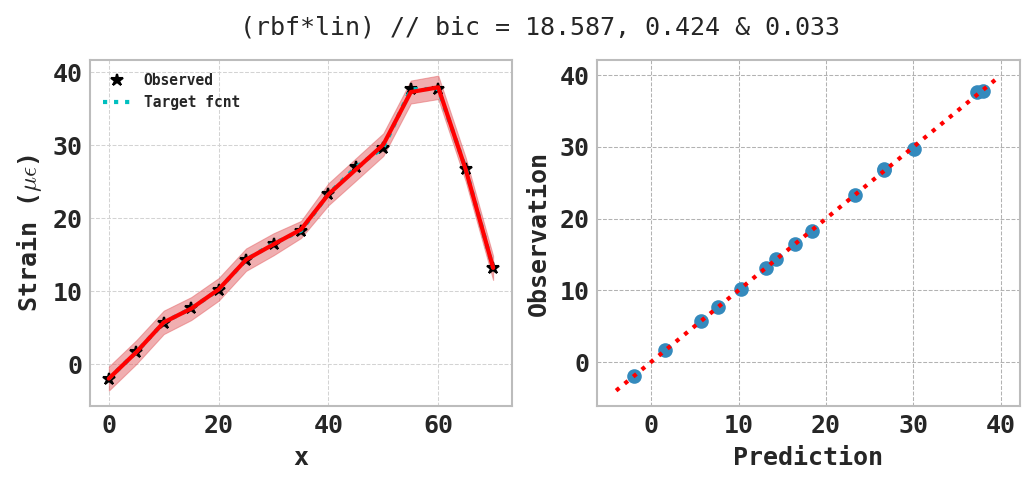

MAE : 0.424 // MSE : 0.033
%%%%%%%%%%%%%%%%%%%%%
List for Loading Case: [0]
# Case : 0


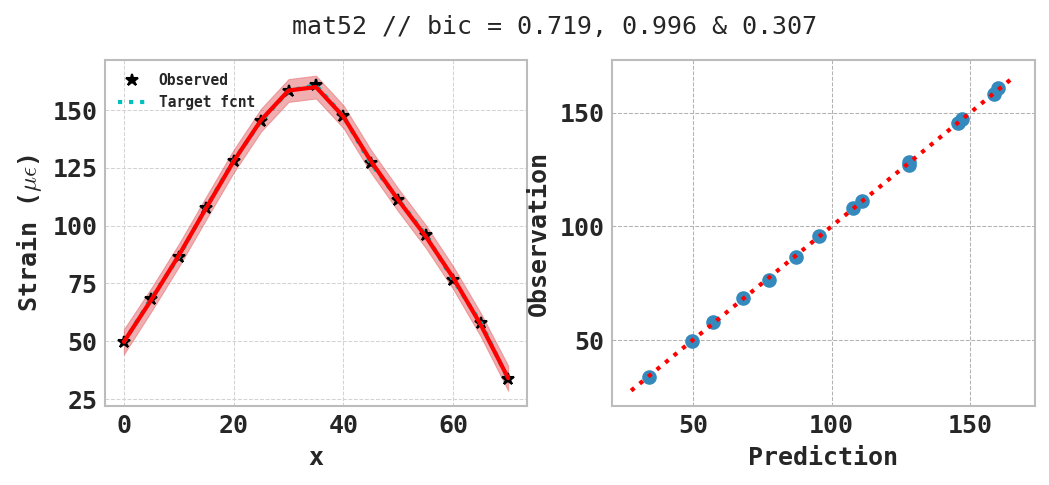

MAE : 0.996 // MSE : 0.307
%%%%%%%%%%%%%%%%%%%%%
List for Loading Case: [0]
# Case : 0


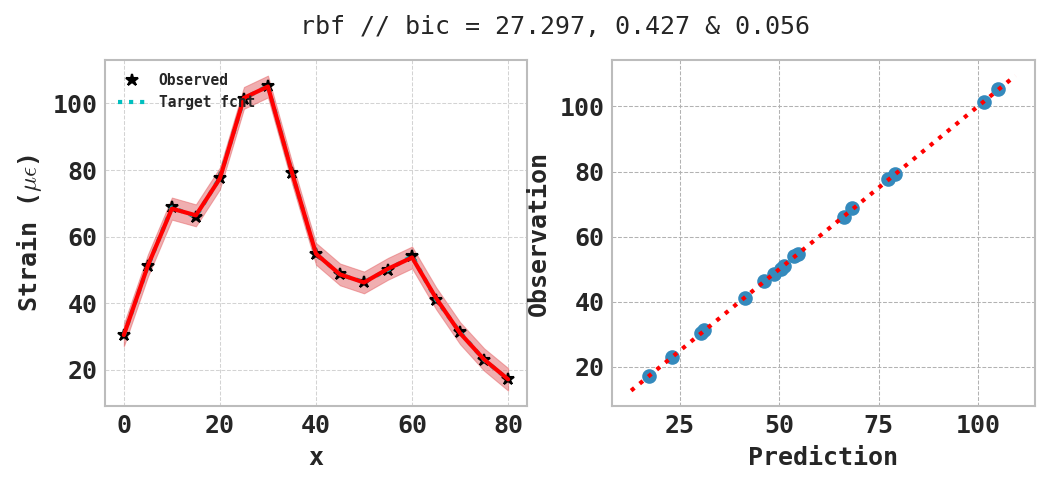

MAE : 0.427 // MSE : 0.056
%%%%%%%%%%%%%%%%%%%%%
List for Loading Case: [0 1]
# Case : 0


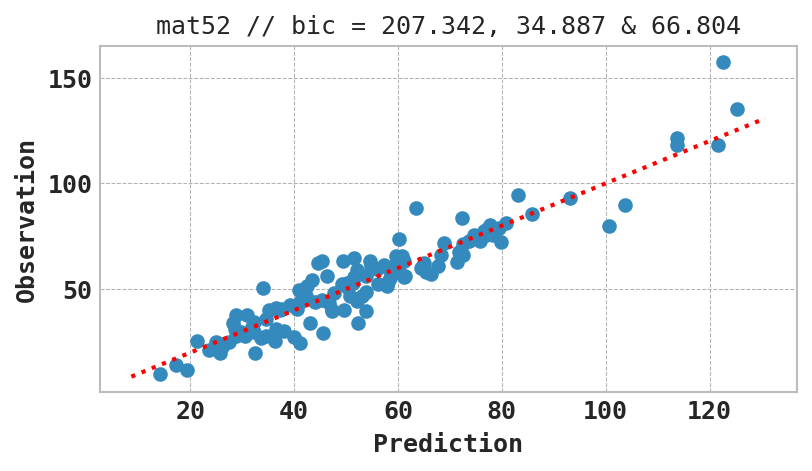

MAE : 34.887 // MSE : 66.804
%%%%%%%%%%%%%%%%%%%%%
# Case : 1


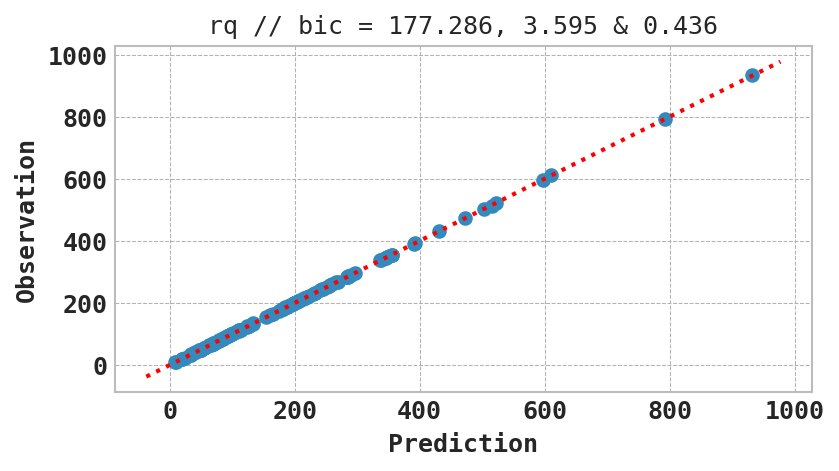

MAE : 3.595 // MSE : 0.436
%%%%%%%%%%%%%%%%%%%%%
List for Loading Case: [0]
# Case : 0


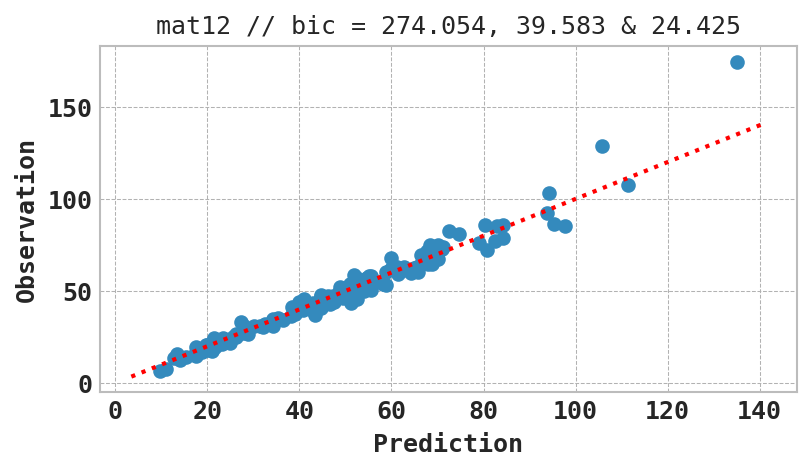

MAE : 39.583 // MSE : 24.425
%%%%%%%%%%%%%%%%%%%%%
List for Loading Case: [0 1 2 3]
# Case : 0


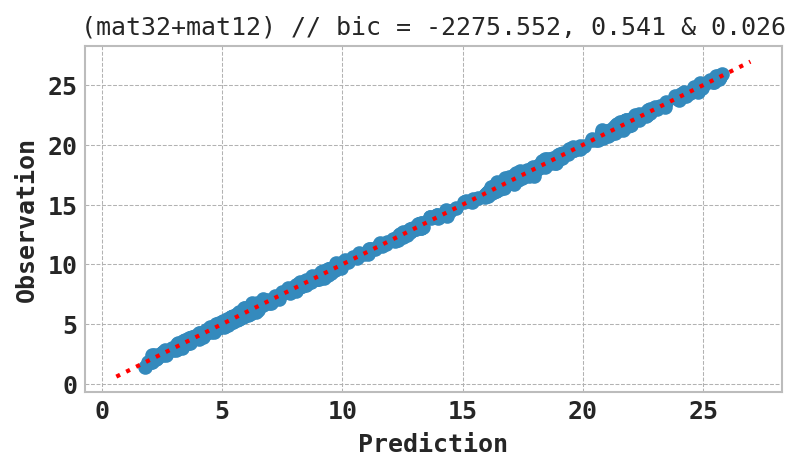

MAE : 0.541 // MSE : 0.026
%%%%%%%%%%%%%%%%%%%%%
# Case : 1


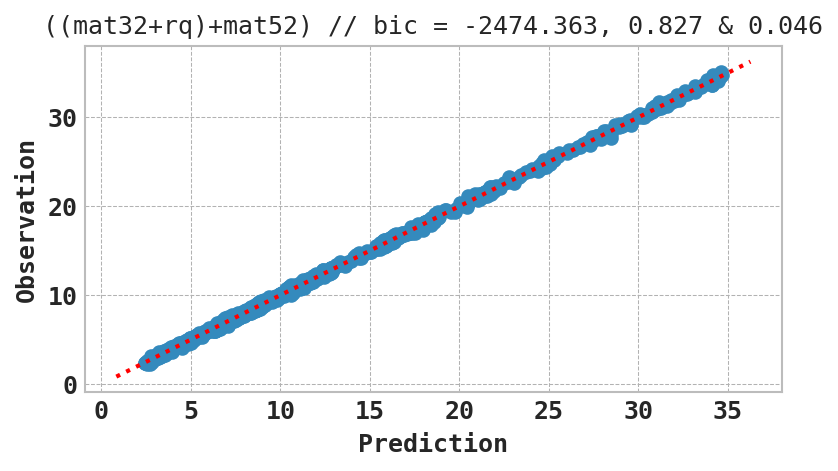

MAE : 0.827 // MSE : 0.046
%%%%%%%%%%%%%%%%%%%%%
# Case : 2


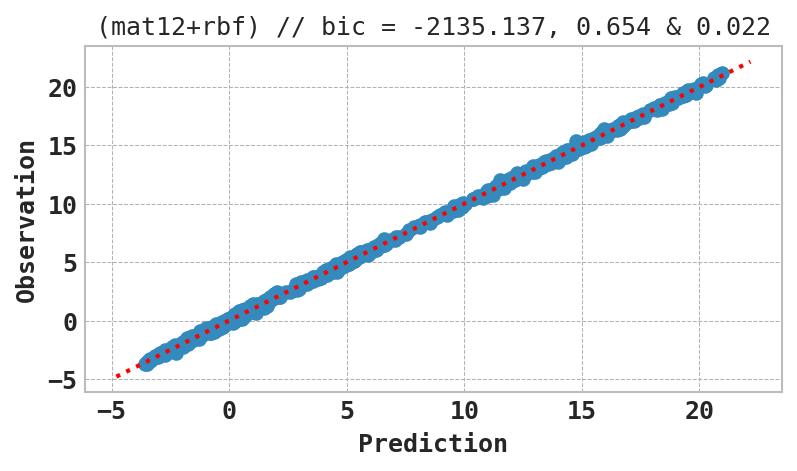

MAE : 0.654 // MSE : 0.022
%%%%%%%%%%%%%%%%%%%%%
# Case : 3


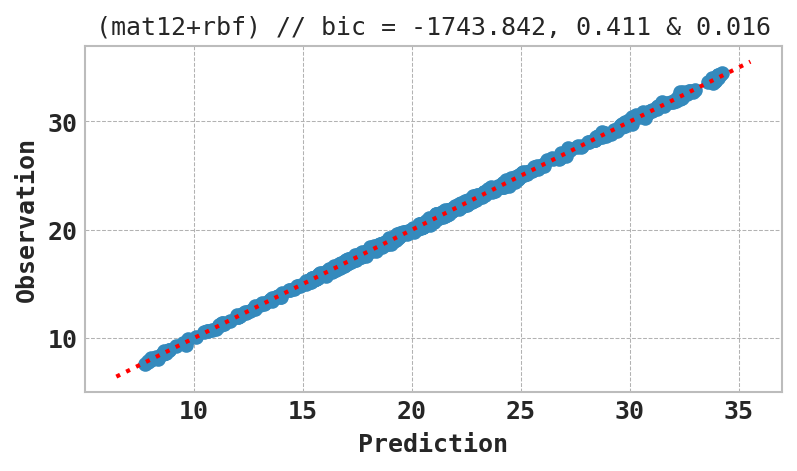

MAE : 0.411 // MSE : 0.016
%%%%%%%%%%%%%%%%%%%%%


In [5]:
import pickle

data_type = 'LF'
fn_lists_LF = [
    f'simplebeam_strain_{data_type}0.csv',
    f'simplebeam_strain_{data_type}1.csv',
    f'simplebeam_strain_{data_type}2.csv',
    f'slab1_strain_{data_type}.csv',
    f'slab2_strain_{data_type}.csv',
    f'Yongsu_strain_{data_type}.csv',
]

if 1:
    rand_seed0, plot_on = 1234, False

    for fn in fn_lists_LF:
        fn_str = fn.split('_')

        # Import HF-data
        df = pd.read_csv('./Data/' + fn)
        if df.shape[1] == 2: # 1d
            i_loads, input_dim = np.arange(df.shape[1] - 1), 1
        else:
            i_loads, input_dim = np.arange(df.shape[1] - 2), 2

        print(f"List for Loading Case: {i_loads}")

        for i_load in i_loads:
            # Set testdata
            if input_dim == 1: # 1D
                trainset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values))
                testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values))
            else: # 2D
                testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values))
                trainset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values))

            # Fit GPModel using subsets of HF-data
            print(f"# Case : {i_load}") # df_tmp.shape[0]
            
            plot_on = True
            best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, options, plot_on)
            mae, mse = best_metrics[best_index, :]
            
            # Save best and worst GPModels
            fn_sv = f"Best_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pth"
            torch.save(best_model.state_dict(), dir_fitted_result + f'/{fn_sv}')
            
            # Save trainingset
            fn_train_sv = f"{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pkl"
            values_saved = {
                'trainingset': trainset, 'testset': testset, 'CPKL_str': best_model.kernel_type
                }
            
            with open(dir_trainset + '/' + fn_train_sv, 'wb') as file:
                pickle.dump(values_saved, file)

In [40]:
def reconstruct_backbone_model(train_x, train_y, kernel_str):
    # get information trainint set for initializing hyper-parameters
    traindata_info = initialize_hyperparameters(train_x, train_y)

    # Define base_kernels
    base_kernels, likelihood0 = define_base_kernels(train_x, traindata_info)

    kernel_type_splitted = kernel_str.replace('(', '')
    kernel_type_splitted = kernel_type_splitted.replace(')', '')
    kernel_type_splitted = kernel_type_splitted.replace('+', ' + ')
    kernel_type_splitted = kernel_type_splitted.replace('*', ' * ')
    kernel_type_splitted = kernel_type_splitted.split(' ')

    # Define Learned kernels => it can be single or compositional kernel
    if len(kernel_type_splitted) == 1: # Single kernel
        kernel_ = base_kernels[kernel_type_splitted[0]]()
        
    else: # Composition using two more kernels
        kernel_ = base_kernels[kernel_type_splitted[0]]()
        for key in kernel_type_splitted[1:]:
            if key in ['*', '+']:
                compotional_rule = key
            else:
                if compotional_rule == '+':
                    kernel_ = kernel_ + base_kernels[key]()
                else:
                    kernel_ = kernel_ * base_kernels[key]()

    # Construct GPModel based on the kernel learned before
    model_ = ExactGPModel(deepcopy(train_x), deepcopy(train_y), kernel_, kernel_str, deepcopy(likelihood0), options).float()

    return model_

simplebeam_strain_LF0.csv


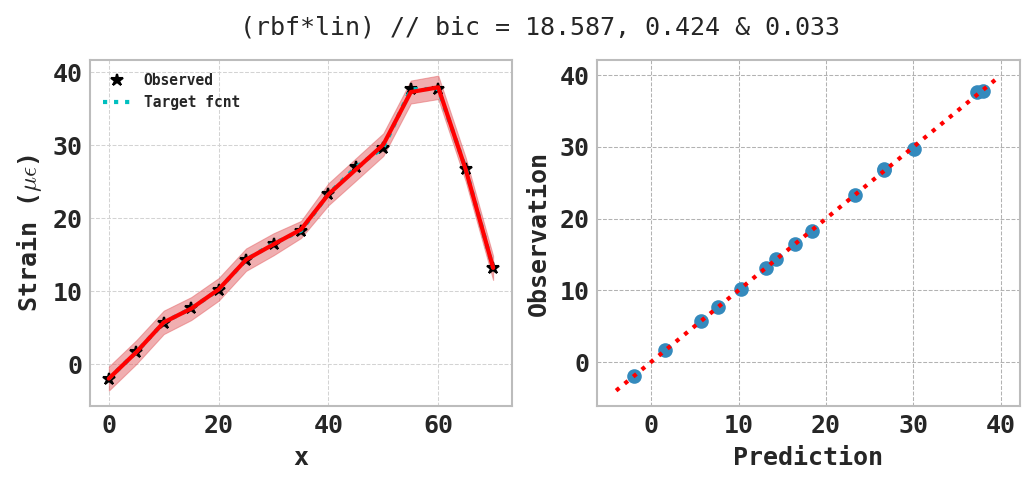

MAE : 0.424 // MSE : 0.033
%%%%%%%%%%%%%%%%%%%%%
simplebeam_strain_LF1.csv


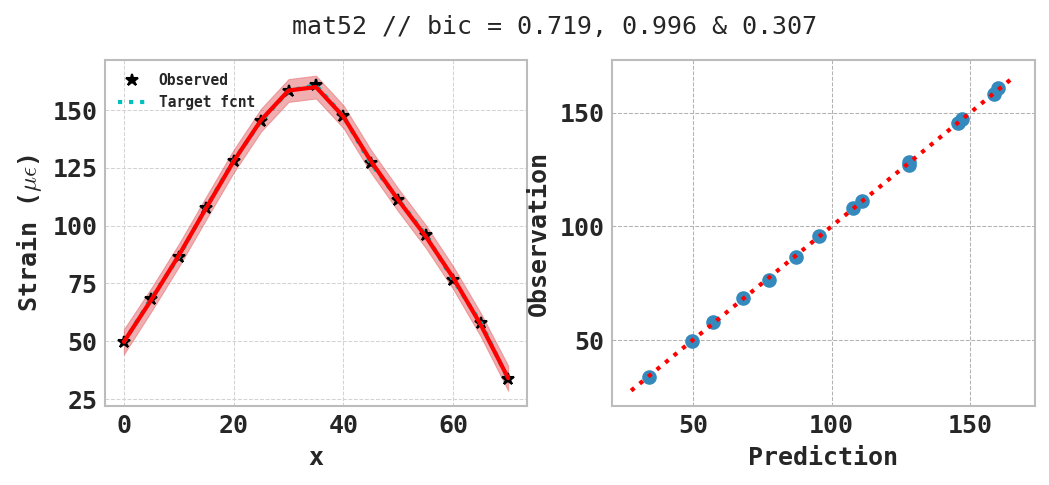

MAE : 0.996 // MSE : 0.307
%%%%%%%%%%%%%%%%%%%%%
simplebeam_strain_LF2.csv


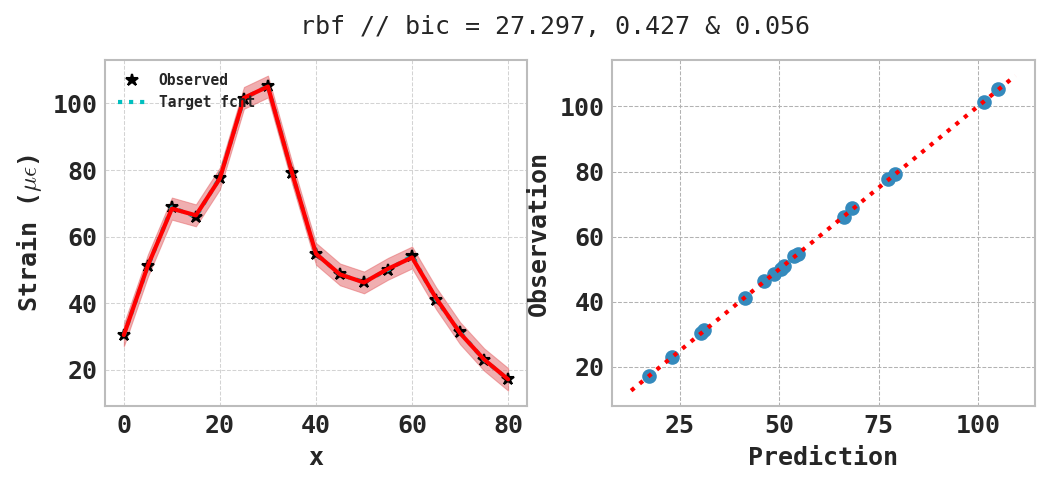

MAE : 0.427 // MSE : 0.056
%%%%%%%%%%%%%%%%%%%%%
slab1_strain_LF.csv


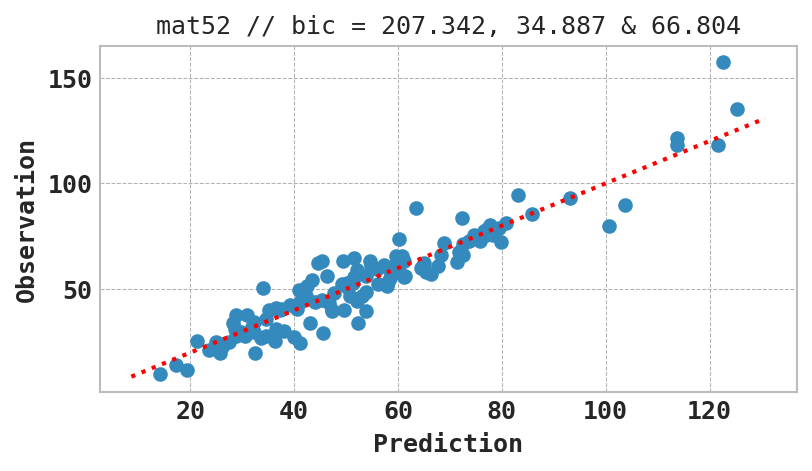

MAE : 34.887 // MSE : 66.804
%%%%%%%%%%%%%%%%%%%%%
slab1_strain_LF.csv


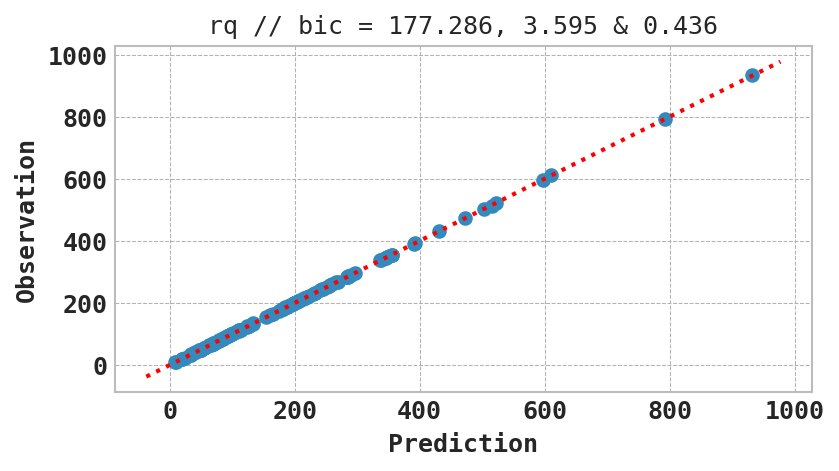

MAE : 3.595 // MSE : 0.436
%%%%%%%%%%%%%%%%%%%%%
slab2_strain_LF.csv


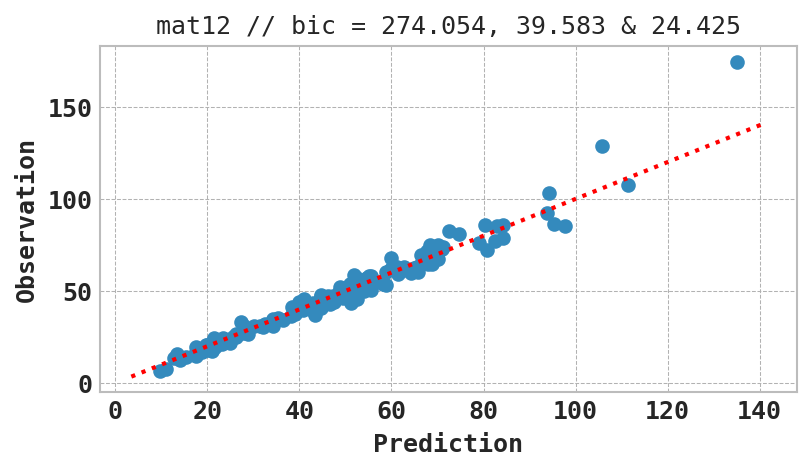

MAE : 39.583 // MSE : 24.425
%%%%%%%%%%%%%%%%%%%%%
Yongsu_strain_LF.csv


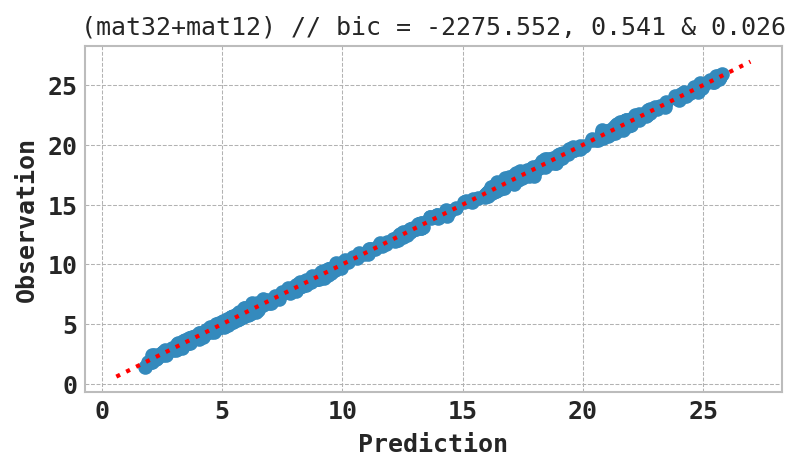

MAE : 0.541 // MSE : 0.026
%%%%%%%%%%%%%%%%%%%%%
Yongsu_strain_LF.csv


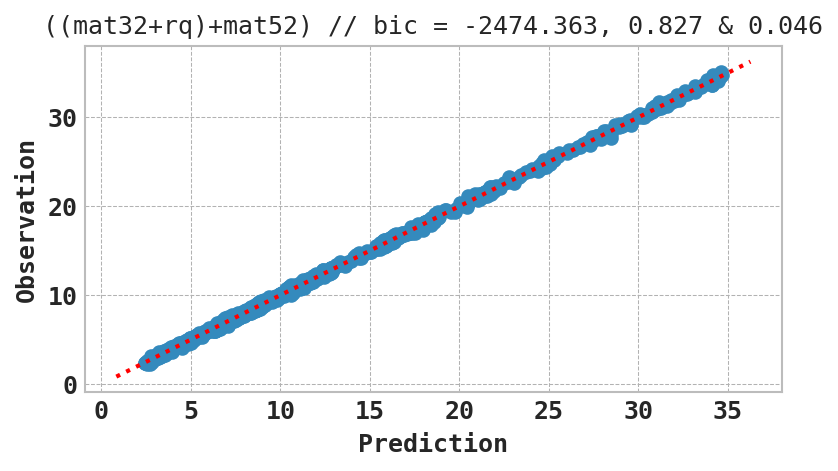

MAE : 0.827 // MSE : 0.046
%%%%%%%%%%%%%%%%%%%%%
Yongsu_strain_LF.csv


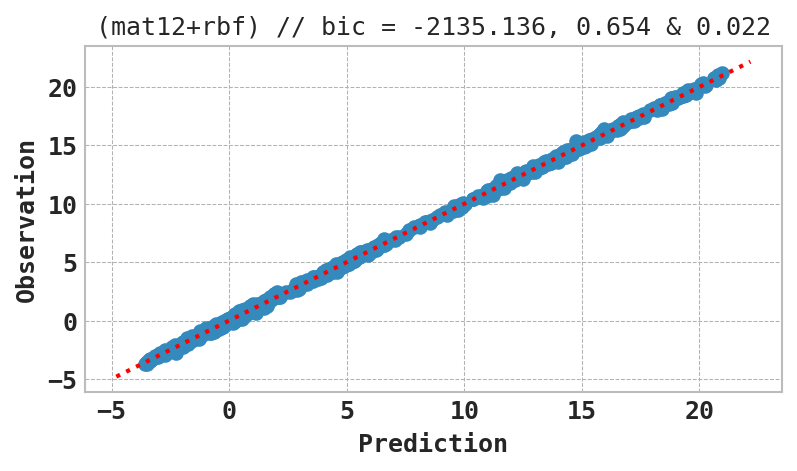

MAE : 0.654 // MSE : 0.022
%%%%%%%%%%%%%%%%%%%%%
Yongsu_strain_LF.csv


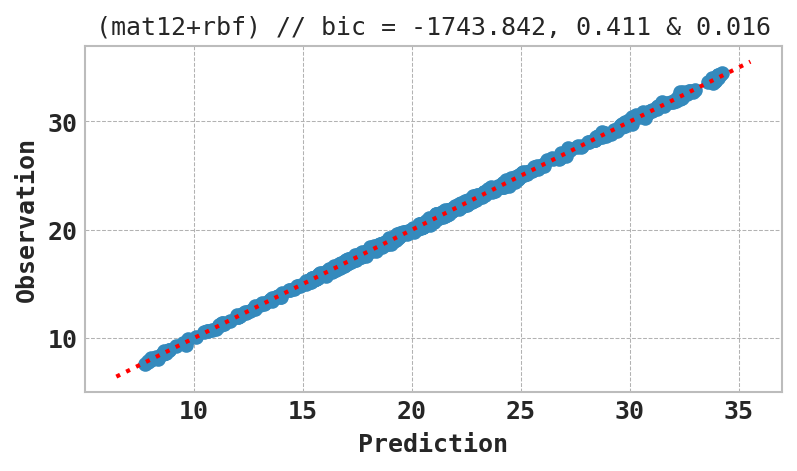

MAE : 0.411 // MSE : 0.016
%%%%%%%%%%%%%%%%%%%%%


In [45]:
i_load_cases = [1, 1, 1, 2, 1, 4]

for fn, i_load_case in zip(fn_lists_LF, i_load_cases):
    fn_str = fn.split('_')

    for i_load in range(i_load_case):
        fn_sv = dir_fitted_result + f"/Best_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pth" # for learned parameters
        fn_train_sv = dir_trainset + f"/{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pkl" # for dataset    

        # 1. Construct backbone model for initialization
        # Load datasets
        with open(fn_train_sv, 'rb') as file:
            dataset = pickle.load(file)

        trainset, testset = dataset['trainingset'], dataset['testset']
        kernel_str = dataset['CPKL_str']

        # Construct a backbone GPModel
        train_x, train_y = testset[1].float(), testset[0].float()
        best_model_ = reconstruct_backbone_model(train_x, train_y, kernel_str)
        
        # 2. Update initial model using parameter values learned    
        state_dict = torch.load(fn_sv) # Load learned values
        best_model_.load_state_dict(state_dict)
        
        # Make prediction
        test_x, test_y = testset[1].float(), testset[0].float()
        
        print(fn)
        mae, mse = plot_result(best_model_, test_x, test_y, plot_on = True)
        print(f"MAE : {mae:.3f} // MSE : {mse:.3f}")
        print("%%%%%%%" * 3)

### **2. Construct GPModels using only HF-data (i.e. subsets)**

In [ ]:
import pickle

data_type = 'HF'
fn_lists_HF = [
    f'simplebeam_strain_{data_type}0.csv',
    f'simplebeam_strain_{data_type}1.csv',
    f'simplebeam_strain_{data_type}2.csv',
    f'slab1_strain_{data_type}.csv',
    f'slab2_strain_{data_type}.csv',
    f'Yongsu_strain_{data_type}.csv',
]

ratio_min, ratio_max = 0.3, 0.7
i_sample_min, i_sample_max = 6, 10
rand_seed0, plot_on = 1234, False
n_rep = 10

if 1:
    for fn in fn_lists_HF:
        fn_str = fn.split('_')

        # Import HF-data
        df = pd.read_csv('./Data/' + fn)
        if df.shape[1] == 2: # 1d
            i_loads, input_dim = np.arange(df.shape[1] - 1), 1
        else:
            i_loads, input_dim = np.arange(df.shape[1] - 2), 2

        print(f"List for Loading Case: {i_loads}")

        for i_load in i_loads:
            # Set testdata
            if input_dim == 1:
                testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim].values)) # 1D
            else:
                testset = (torch.tensor(df.iloc[:, i_load].values), torch.tensor(df.iloc[:, -input_dim:].values)) # 1D

            # Loop for generating trainingset via stratified sampling
            if input_dim == 1:
                i_samples = np.unique(np.linspace(df.shape[0] * ratio_min, df.shape[0] * ratio_max, 5, dtype = int))
            else:
                i_samples = np.unique(np.arange(i_sample_min, i_sample_max + 1, dtype = int))

            print(f"List for # Samples: {i_samples}")

            best_trainingsets, worst_trainingsets = [], []
            best_kernel_types, worst_kernel_types = [], []
            train_set_all_mae, train_set_all_mse = np.full((n_rep,1),np.nan), np.full((n_rep,1),np.nan)
            for ind_sample in i_samples: # increase # of HF-data
                if input_dim == 1:
                    # Get minimal and maximal inputs
                    xmin_, xmax_ = testset[-1].min(), testset[-1].max()
                    
                    # Generate stratified intervals (cut_interval)
                    cut_interval = np.linspace(xmin_, xmax_, ind_sample + 1)
                    cut_interval[0], cut_interval[-1] = - np.inf, np.inf

                    df['cut'] = pd.cut(df['x'], bins = cut_interval, labels = [i for i in range(cut_interval.shape[0] - 1)])
                    tmp = df.groupby('cut', group_keys=False)
                    
                    train_set_mae, train_set_mse = [], []
                    train_set, model_list = [], []

                    for i_rep in range(n_rep): # repeat random sampling based on stratified intervals
                        df_tmp = tmp.apply(lambda x: x.sample(1, replace=True, random_state = rand_seed0 * i_rep))
                        df_tmp.drop('cut', axis=1, inplace=True)
                        
                        trainset = (torch.tensor(df_tmp.iloc[:, i_load].values), torch.tensor(df_tmp.iloc[:, -input_dim].values))

                        # Fit GPModel using subsets of HF-data
                        print(f"[{i_rep + 1}/{n_rep}] # sample : {ind_sample} // # Case : {i_load}") # df_tmp.shape[0]
                        best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, plot_on)
                        mae, mse = best_metrics[best_index, :]

                        # Append GPModel
                        model_list.append(best_model)
                        train_set_mae.append(mae.item())
                        train_set_mse.append(mse.item())
                        train_set.append(df_tmp)

                else: # 2D
                        np.random.seed(rand_seed0) # for reproducibility
                        if fn_str[0] == 'slab1': # LF-data at x = 300 was not measured
                            df_tmp = df.iloc[3:, :]
                            
                        else:
                            df_tmp = df.iloc[:, :]

                        train_set_mae, train_set_mse = [], []
                        train_set, model_list = [], []

                        for i_rep in range(n_rep): # repeat random sampling based on stratified intervals
                            ind_train = np.random.choice(df_tmp.shape[0], ind_sample, replace=False)
                            trainset = (torch.tensor(df_tmp.iloc[ind_train, i_load].values), torch.tensor(df_tmp.iloc[ind_train, -input_dim:].values))
                            
                            plot_on = True
                            
                            # Fit GPModel using subsets of HF-data
                            print(f"[{i_rep + 1}/{n_rep}] # sample : {ind_sample} // # Case : {i_load}") # df_tmp.shape[0]
                            best_model, best_models, best_metrics, best_index = run_experimental_data_for_CPKL(deepcopy(trainset), deepcopy(testset), rand_seed0, plot_on)
                            mae, mse = best_metrics[best_index, :]

                            # Append GPModel
                            model_list.append(best_model)
                            train_set_mae.append(mae.item())
                            train_set_mse.append(mse.item())
                            train_set.append(df_tmp.iloc[ind_train, i_load])

                # Find indices of best and worst model
                train_set_mae = np.array(train_set_mae).reshape(-1, 1)
                train_set_mse = np.array(train_set_mse).reshape(-1, 1)

                ind_best = np.array(train_set_mae).argmin()
                ind_worst = np.array(train_set_mae).argmax()

                # Save best and worst GPModels
                fn_sv = f"Best_{fn_str[0]}_{fn_str[-1].split('.')[0]}_N{ind_sample}_Case{i_load}.pth"
                torch.save(model_list[ind_best].state_dict(), f'{dir_fitted_result}/{fn_sv}')

                fn_sv = f"Worst_{fn_str[0]}_{fn_str[-1].split('.')[0]}_N{ind_sample}_Case{i_load}.pth"
                torch.save(model_list[ind_worst].state_dict(), f'{dir_fitted_result}/{fn_sv}')
                
                best_kernel_types.append(model_list[ind_best].kernel_type)
                worst_kernel_types.append(model_list[ind_worst].kernel_type)

                # Append training data & metrics
                best_trainingsets.append(train_set[ind_best])
                worst_trainingsets.append(train_set[ind_worst])
                if np.isnan(train_set_all_mae).all():
                    train_set_all_mae, train_set_all_mse = train_set_mae, train_set_mse
                else:
                    train_set_all_mae = np.concatenate([train_set_all_mae, train_set_mae], axis = 1)
                    train_set_all_mse = np.concatenate([train_set_all_mse, train_set_mse], axis = 1)

        df_mae = pd.DataFrame(train_set_all_mae)
        df_mae.columns = i_samples
        df_mse = pd.DataFrame(train_set_all_mse)
        df_mse.columns = i_samples

        df_mae.to_csv(dir_trainset + '/' + f"MAE_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.csv")
        df_mse.to_csv(dir_trainset + '/' + f"MSE_{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.csv")

        # Save trainingset
        fn_train_sv = f"{fn_str[0]}_{fn_str[-1].split('.')[0]}_Case{i_load}.pkl"
        values_saved = {
            'best_trainingsets': best_trainingsets, 'worst_trainingsets': worst_trainingsets, 'testset': testset,
            'best_CPKL_str': best_kernel_types, 'worst_CPKL_str': worst_kernel_types,
            }
        
        with open(dir_trainset + '/' + fn_train_sv, 'wb') as file:
            pickle.dump(values_saved, file)

### **3. Complimentary Data-fusion: Multi-fidelity approach**

In [ ]:
# def get_dataset_of_fitted_GPModels(dataset_fn):
#     with open(dataset_fn, 'rb') as f:
#         dict = pickle.load(f)

#     trainingset = dict['trainingset']
#     testset = dict['testset']
#     testset

# def get_result_of_fitted_GPModels(model_fn):
#     with open(model_fn, 'rb') as f:
#         dict = pickle.load(f)

#     trainingset = dict['trainingset']
#     testset = dict['testset']
#     testset

In [ ]:
# import glob

# data_type = 'LF'
# fn_lists_LF = [
#     f'simplebeam_strain_{data_type}0.csv',
#     f'simplebeam_strain_{data_type}1.csv',
#     f'simplebeam_strain_{data_type}2.csv',
#     f'slab1_strain_{data_type}.csv',
#     f'slab2_strain_{data_type}.csv',
#     f'Yongsu_strain_{data_type}.csv',
# ]

# # Import GPModels fitted by LF-data
# for fn in fn_lists_LF:
#     fn_splited = fn.split('_')
#     fn_target = f"{fn_splited[0]}_{fn_splited[-1].split('.')[0]}"
#     # Check # of cases (loading => i_load)
#     LF_model_fn_lists = glob.glob(dir_fitted_result + f'/Best_{fn_target}_*.pth')

#     for LF_model_fn in LF_model_fn_lists:
#         LF_model_fn
    
#     print(output)
#     # break

# # Dataset
# # dir_trainset

# # Fitted GPModels
# # dir_fitted_result

# # with open(dir_trainset + '/' + fn_train_list[0], 'rb') as f:
# #     dict = pickle.load(f)

# # trainingset = dict['trainingset']
# # testset = dict['testset']
# # testset

In [ ]:


data_type = 'HF'
fn_lists_HF = [
    f'simplebeam_strain_{data_type}0.csv',
    f'simplebeam_strain_{data_type}1.csv',
    f'simplebeam_strain_{data_type}2.csv',
    f'slab1_strain_{data_type}.csv',
    f'slab2_strain_{data_type}.csv',
    f'Yongsu_strain_{data_type}.csv',
]